# Lemmatize file with Perseids Morpheus Parser

## Access Perseids Morpheus and query Lemmata and Morphology

In [1]:
## Test
import sys
import requests # query website
import json
from nltk.tokenize import RegexpTokenizer # tokenize
URL = "http://morph.perseids.org/analysis/word?lang=grc&engine=morpheusgrc"
  
# location given here 
location = "ἀλλά"
  
# defining a params dict for the parameters to be sent to the API 
PARAMS = {'word':location} 
  
# sending get request and saving the response as response object 
r = requests.get(url = URL, params = PARAMS) 
  
# extracting data in json format 
data = r.json() 
print(data)

{'RDF': {'Annotation': {'about': 'urn:TuftsMorphologyService:ἀλλά:morpheusgrc', 'creator': {'Agent': {'about': 'org.perseus:tools:morpheus.v1'}}, 'created': {'$': '2020-01-01T00:00:00.000000'}, 'hasTarget': {'Description': {'about': 'urn:word:ἀλλά'}}, 'title': {}, 'hasBody': {'resource': 'urn:uuid:idm14f6d0fe9b95796b17417644579e42a2c320d2fa8c00da763451e8e1a2391384'}, 'Body': {'about': 'urn:uuid:idm14f6d0fe9b95796b17417644579e42a2c320d2fa8c00da763451e8e1a2391384', 'type': {'resource': 'cnt:ContentAsXML'}, 'rest': {'entry': {'uri': None, 'dict': {'hdwd': {'lang': 'grc', '$': 'ἀλλά'}, 'pofs': {'order': 7, '$': 'adverb'}}, 'infl': {'term': {'lang': 'grc', 'stem': {'$': 'ἀλλά'}}, 'pofs': {'order': 7, '$': 'adverb'}, 'stemtype': {'$': 'adverb'}, 'morph': {'$': 'indeclform'}}}}}}}}


In [4]:
import sys
import requests # query website
import json
from nltk.tokenize import RegexpTokenizer # tokenize
def queryMorpheusLem(word):
    """Works only online. Query Perseids Morpeus for Lemma (code inspired by ideas from CLTK's lemma.py)."""
    suche = {"word": word}
    try:
        r = requests.get('http://morph.perseids.org/analysis/word?lang=grc&engine=morpheusgrc', params=suche, timeout=10)
    except requests.exceptions.Timeout:
        print("Timeout. Please try again.")
    else:
        data = r.json()
        result = {} # output results as dictionary
        result["Word"] = word
        try:
            entry = data["RDF"]["Annotation"]["Body"]
        except KeyError:
            result["Lemma"] = word # Copy word as lemma 
            result["Morphology"] = "NOT FOUND"
            #result["Error"] = "NOT FOUND"  # error indicator
        else:
            # Test if there are more entries
            # TODO: Better way to deal with words with more lemma entries: how to find the correct lemma?
            try: 
                entry[1]["rest"]
                list_hdwd = []
                list_pos = []
                for i in range(len(entry)):
                    headword = entry[i]["rest"]["entry"]["dict"]["hdwd"]["$"]
                    infl = entry[i]["rest"]["entry"]["infl"]
                    if isinstance(infl, list):
                        list_pos1 = []
                        for inst in range(len(infl)):
                            POS = infl[inst]["pofs"]["$"]
                            if POS == "verb":
                                MOOD = infl[inst]["mood"]["$"]
                                TENSE = infl[inst]["tense"]["$"]
                                VOICE = infl[inst]["voice"]["$"]
                                try:
                                    NUM = infl[inst]["num"]["$"]
                                    PERS = infl[inst]["pers"]["$"]
                                    posentry = POS+"-"+MOOD+"-"+NUM+"-"+PERS+"-"+TENSE+"-"+VOICE
                                except KeyError:
                                    posentry = POS+"-"+MOOD+"-"+TENSE+"-"+VOICE
                            elif POS == "verb participle":
                                CASE = infl[inst]["case"]["$"]
                                GEND = infl[inst]["gend"]["$"]
                                NUM = infl[inst]["num"]["$"]                                
                                TENSE = infl[inst]["tense"]["$"]
                                try:
                                    VOICE = infl[inst]["voice"]["$"]  
                                    posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM+"-"+TENSE+"-"+VOICE
                                except KeyError:
                                    posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM+"-"+TENSE
                            elif POS == "pronoun":
                                CASE = infl[inst]["case"]["$"]
                                NUM = infl[inst]["num"]["$"]
                                posentry = POS+"-"+CASE+"-"+NUM
                            elif POS == "noun":
                                try:
                                    CASE = infl[inst]["case"]["$"]
                                    GEND = infl[inst]["gend"]["$"]
                                    NUM = infl[inst]["num"]["$"]
                                    posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                                except KeyError:
                                    TYPE = infl[inst]["stemtype"]["$"]
                                    posentry = POS+"-"+TYPE
                            elif POS == "article":
                                CASE = infl[inst]["case"]["$"]
                                GEND = infl[inst]["gend"]["$"]
                                NUM = infl[inst]["num"]["$"]
                                posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                            elif POS == "adjective":
                                try:
                                    GEND = infl[inst]["gend"]["$"]
                                    if GEND == "adverbial":
                                        posentry = POS+"-"+GEND
                                    else:
                                        try:
                                            MORPH = infl[inst]["morph"]["$"]
                                            posentry = POS+"-"+GEND+"-"+MORPH
                                        except KeyError:
                                            CASE = infl[inst]["case"]["$"]
                                            NUM = infl[inst]["num"]["$"]
                                            try:
                                                COMP = infl[inst]["comp"]["$"]
                                                posentry = POS+"-"+CASE+"-"+GEND+"-"+COMP+"-"+NUM
                                            except KeyError:
                                                posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                                except KeyError:
                                    CASE = infl[inst]["case"]["$"]
                                    NUM = infl[inst]["num"]["$"]
                                    try:
                                        COMP = infl[inst]["comp"]["$"]
                                        posentry = POS+"-"+CASE+"-"+COMP+"-"+NUM
                                    except KeyError:
                                        posentry = POS+"-"+CASE+"-"+NUM
                            else:
                                posentry = POS
                            list_pos1.append(posentry)
                        instance = "/".join(list_pos1)
                        list_pos.append(instance)
                    else:
                        POS = infl["pofs"]["$"]
                        if POS == "verb":
                            MOOD = infl["mood"]["$"]
                            TENSE = infl["tense"]["$"]
                            VOICE = infl["voice"]["$"]
                            try:
                                NUM = infl["num"]["$"]
                                PERS = infl["pers"]["$"]
                                posentry = POS+"-"+MOOD+"-"+NUM+"-"+PERS+"-"+TENSE+"-"+VOICE
                            except KeyError:
                                posentry = POS+"-"+MOOD+"-"+TENSE+"-"+VOICE
                        elif POS == "verb participle":
                            CASE = infl["case"]["$"]
                            GEND = infl["gend"]["$"]
                            NUM = infl["num"]["$"]                                
                            TENSE = infl["tense"]["$"]
                            VOICE = infl["voice"]["$"]  
                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM+"-"+TENSE+"-"+VOICE      
                        elif POS == "pronoun":
                            CASE = infl["case"]["$"]
                            NUM = infl["num"]["$"]
                            posentry = POS+"-"+CASE+"-"+NUM
                        elif POS == "noun":
                            try:
                                CASE = infl["case"]["$"]
                                GEND = infl["gend"]["$"]
                                NUM = infl["num"]["$"]
                                posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM    
                            except KeyError:
                                TYPE = infl["stemtype"]["$"]
                                posentry = POS+"-"+TYPE
                        elif POS == "article":
                            CASE = infl["case"]["$"]
                            GEND = infl["gend"]["$"]
                            NUM = infl["num"]["$"]
                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                        elif POS == "adjective":
                            try:
                                GEND = infl["gend"]["$"]
                                if GEND == "adverbial":
                                    posentry = POS+"-"+GEND
                                else:
                                    try:
                                        MORPH = infl["morph"]["$"]
                                        posentry = POS+"-"+GEND+"-"+MORPH
                                    except KeyError:
                                        CASE = infl["case"]["$"]
                                        NUM = infl["num"]["$"]
                                        try:
                                            COMP = infl["comp"]["$"]
                                            posentry = POS+"-"+CASE+"-"+GEND+"-"+COMP+"-"+NUM
                                        except KeyError:
                                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                            except KeyError:
                                CASE = infl["case"]["$"]
                                NUM = infl["num"]["$"]
                                try:
                                    COMP = infl["comp"]["$"]
                                    posentry = POS+"-"+CASE+"-"+COMP+"-"+NUM
                                except KeyError:
                                    posentry = POS+"-"+CASE+"-"+NUM
                        else:
                            posentry = POS
                        list_pos.append(posentry)
                    list_hdwd.append(headword)
                result["Lemma"] = "|".join(list_hdwd)
                result["Morphology"] = "|".join(list_pos)
            except KeyError:
                headword = entry["rest"]["entry"]["dict"]["hdwd"]["$"]
                infl = entry["rest"]["entry"]["infl"]
                if isinstance(infl, list):
                    list_pos1 = []
                    for inst in range(len(infl)):
                        POS = infl[inst]["pofs"]["$"]
                        if POS == "verb":
                            MOOD = infl[inst]["mood"]["$"]
                            TENSE = infl[inst]["tense"]["$"]
                            VOICE = infl[inst]["voice"]["$"]
                            try:
                                NUM = infl[inst]["num"]["$"]
                                PERS = infl[inst]["pers"]["$"]
                                posentry = POS+"-"+MOOD+"-"+NUM+"-"+PERS+"-"+TENSE+"-"+VOICE
                            except KeyError:
                                posentry = POS+"-"+MOOD+"-"+TENSE+"-"+VOICE
                        elif POS == "verb participle":
                            CASE = infl[inst]["case"]["$"]
                            GEND = infl[inst]["gend"]["$"]
                            NUM = infl[inst]["num"]["$"]                                
                            TENSE = infl[inst]["tense"]["$"]
                            VOICE = infl[inst]["voice"]["$"]  
                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM+"-"+TENSE+"-"+VOICE
                        elif POS == "pronoun":
                            CASE = infl[inst]["case"]["$"]
                            NUM = infl[inst]["num"]["$"]
                            posentry = POS+"-"+CASE+"-"+NUM
                        elif POS == "noun":
                            try:
                                CASE = infl[inst]["case"]["$"]
                                GEND = infl[inst]["gend"]["$"]
                                NUM = infl[inst]["num"]["$"]
                                posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                            except KeyError:
                                TYPE = infl[inst]["stemtype"]["$"]
                                posentry = POS+"-"+TYPE
                        elif POS == "article":
                            CASE = infl[inst]["case"]["$"]
                            GEND = infl[inst]["gend"]["$"]
                            NUM = infl[inst]["num"]["$"]
                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                        elif POS == "adjective":
                            try:
                                GEND = infl[inst]["gend"]["$"]
                                if GEND == "adverbial":
                                    posentry = POS+"-"+GEND
                                else:
                                    try:
                                        MORPH = infl[inst]["morph"]["$"]
                                        posentry = POS+"-"+GEND+"-"+MORPH
                                    except KeyError:
                                        CASE = infl[inst]["case"]["$"]
                                        NUM = infl[inst]["num"]["$"]
                                        try:
                                            COMP = infl[inst]["comp"]["$"]
                                            posentry = POS+"-"+CASE+"-"+GEND+"-"+COMP+"-"+NUM
                                        except KeyError:
                                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                            except KeyError:
                                CASE = infl[inst]["case"]["$"]
                                NUM = infl[inst]["num"]["$"]
                                try:
                                    COMP = infl[inst]["comp"]["$"]
                                    posentry = POS+"-"+CASE+"-"+COMP+"-"+NUM
                                except KeyError:
                                    posentry = POS+"-"+CASE+"-"+NUM
                        else:
                            posentry = POS
                        list_pos1.append(posentry)
                    posentry = "/".join(list_pos1)
                else:
                    POS = infl["pofs"]["$"]
                    if POS == "verb":
                        MOOD = infl["mood"]["$"]
                        TENSE = infl["tense"]["$"]
                        VOICE = infl["voice"]["$"]
                        try:
                            NUM = infl["num"]["$"]
                            PERS = infl["pers"]["$"]
                            posentry = POS+"-"+MOOD+"-"+NUM+"-"+PERS+"-"+TENSE+"-"+VOICE
                        except KeyError:
                            posentry = POS+"-"+MOOD+"-"+TENSE+"-"+VOICE
                    elif POS == "verb participle":
                        CASE = infl["case"]["$"]
                        GEND = infl["gend"]["$"]
                        NUM = infl["num"]["$"]                                
                        TENSE = infl["tense"]["$"]
                        VOICE = infl["voice"]["$"]  
                        posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM+"-"+TENSE+"-"+VOICE
                    elif POS == "pronoun":
                        CASE = infl["case"]["$"]
                        NUM = infl["num"]["$"]
                        posentry = POS+"-"+CASE+"-"+NUM
                    elif POS == "noun":
                        try:
                            CASE = infl["case"]["$"]
                            GEND = infl["gend"]["$"]
                            NUM = infl["num"]["$"]
                            posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM 
                        except KeyError:
                            TYPE = infl["stemtype"]["$"]
                            posentry = POS+"-"+TYPE
                    elif POS == "article":
                        CASE = infl["case"]["$"]
                        GEND = infl["gend"]["$"]
                        NUM = infl["num"]["$"]
                        posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                    elif POS == "adjective":
                        try:
                            GEND = infl["gend"]["$"]
                            if GEND == "adverbial":
                                posentry = POS+"-"+GEND
                            else:
                                try:
                                    MORPH = infl["morph"]["$"]
                                    posentry = POS+"-"+GEND+"-"+MORPH
                                except KeyError:
                                    CASE = infl["case"]["$"]
                                    NUM = infl["num"]["$"]
                                    try:
                                        COMP = infl["comp"]["$"]
                                        posentry = POS+"-"+CASE+"-"+GEND+"-"+COMP+"-"+NUM
                                    except KeyError:
                                        posentry = POS+"-"+CASE+"-"+GEND+"-"+NUM
                        except KeyError:
                            CASE = infl["case"]["$"]
                            NUM = infl["num"]["$"]
                            try:
                                COMP = infl["comp"]["$"]
                                posentry = POS+"-"+CASE+"-"+COMP+"-"+NUM
                            except KeyError:
                                posentry = POS+"-"+CASE+"-"+NUM                            
                    else:
                        posentry = POS
                result["Lemma"] = headword
                result["Morphology"] = posentry
        return result

## Test with single word

In [2]:
queryMorpheusLem("ἀλλὰ")

{'Word': 'ἀλλὰ', 'Lemma': 'ἀλλά', 'Morphology': 'adverb'}

## Test with file

Perseids Morpheus can only queried word by word. This takes quite some time... If a queried token was already queried before and therefore is already in the list, then the result is copied from list and Morpheus will not be queried for this token again. This speeds up the query. 
Also, the lemmatizer writes the results into a file `wordlemma.json`. This json-File is also used to speed up further queries.

In [5]:
def loadingBar(count,total,size):
    percent = float(count)/float(total)*100
    sys.stdout.write("\r" + str(int(count)).rjust(3,'0')+"/"+str(int(total)).rjust(3,'0') + ' [' + '='*int(percent/10)*size + ' '*(10-int(percent/10))*size + ']')
    
word_breaks = RegexpTokenizer(r'\w+') # whitespace tokenize
data_file = open('wordlemma_grc.json')    
lemma_data = json.load(data_file)
with open('/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext/pta0007.pta007.pta-grc1.txt', 'r') as f:
    f = f.read().lower()
    tokens = word_breaks.tokenize(f)
    lemmatized = []
    count = 0
    for token in tokens:
        #print(token)
        count = count+1
        loadingBar(count,len(tokens),2)
        # check if queried token already in list, if yes, copy from list and don't query Morpheus for speedup
        if any(d["Word"] == token for d in lemmatized):
            matches = next(d for d in lemmatized if token == d["Word"])
            lemmatized.append(matches)
        # check if queried token already in wordlemma.json, if yes, copy from wordlemma and don't query Morpheus for speedup    
        elif any(d["Word"] == token for d in lemma_data):
            matches = next(d for d in lemma_data if token == d["Word"])
            lemmatized.append(matches)
        else:
            result = queryMorpheusLem(token)
            lemmatized.append(result)
# Delete duplicates from list and write to json file
merged_data = lemma_data + lemmatized
liste = [i for n, i in enumerate(merged_data) if i not in merged_data[n + 1:]]

12334/12334 [====================]

In [6]:
# remove errors from liste for writing to wordlemma.json
for item in liste:
    if "NOT FOUND" in item["Morphology"]:
        liste.remove(item)
with open('wordlemma_grc.json', 'w') as fout:
    json.dump(liste, fout, indent=4, ensure_ascii=False)

TODO: Manual cleanup of wordlemma.json to remove obviously wrong entries ("errors") and to choose the most probable entry in case of ambiguous results.

## Find problematic entries (and therefore possible errors in analyzed text file)
Write these entries into file `errors.json` for further inspection.

In [7]:
errors = []
liste = [i for n, i in enumerate(lemmatized) if i not in lemmatized[n + 1:]] # remove duplicates
for item in liste:
    if item["Morphology"] == "NOT FOUND":
        errors.append(item)
with open('errors-pta0007.pta0007.pta-grcBibex.json', 'w') as fout:
    json.dump(errors, fout, indent=4, ensure_ascii=False)

## Print lemmatized file and file with morphological information

In [38]:
lemmata = [d['Lemma'] for d in lemmatized] # change 'Lemma' to 'Word' to play with words

In [43]:
#extract all lemmata from list and print
#print("\n"+" ".join(lemmata))
lemmata = [pos.split('|', 1)[0] for pos in lemmata] # split entry by  | , i.e. only first option
#save as file:
with open('/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_lemmatized/pta0001.pta010-6.pta-grc1_lemmatized.txt', 'w') as f:
     f.write(" ".join(lemmata))   
# morphology - extract only POS
morph = [d['Morphology'] for d in lemmatized] # Morphological data
morph = [x for x in morph if x != "NOT FOUND"] # remove "NOT FOUND"
morph2 = [pos.split('-', 1)[0] for pos in morph] # extract POS from values (only first one, i.e. split entry by -)
morph2 = [pos.split('/', 1)[0] for pos in morph2] # split entry by remaining /
morph2 = [pos.split('|', 1)[0] for pos in morph2] # split entry by remaining |
with open('/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_morph/pta0001.pta010-6.pta-grc1_morph.txt', 'w') as f:
     f.write(" ".join(morph2))  

## Play with count of lemmata

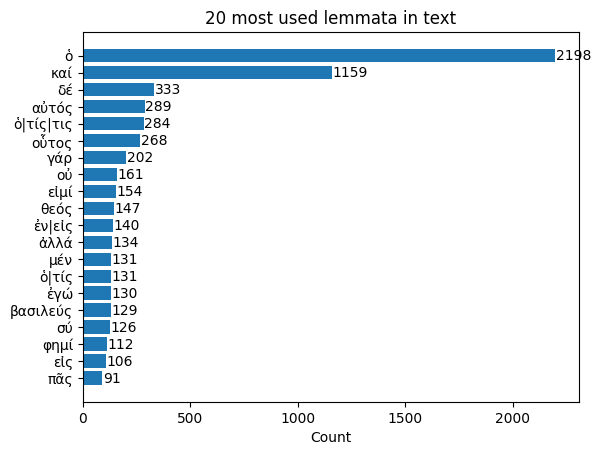

In [39]:
# lemmata = [d['Lemma'] for d in lemmatized] # change 'Lemma' to 'Word' to play with words
# count instances of lemmata (and remove duplicates)
lemma_count = {x:lemmata.count(x) for x in lemmata}
# sort by value in reversed oder (= from most to least)
lemma_sorted = {k: v for k, v in sorted(lemma_count.items(), key=lambda x: x[1], reverse=True)} 
# only first 20 entries
lemma20 = {k: lemma_sorted[k] for k in list(lemma_sorted)[:20]} 
lemma20 = {k: v for k, v in sorted(lemma20.items(), key=lambda x: x[1])} # re-sort

## Plot these 20 lemmata
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

#fig = plt.figure(figsize=(6,10))
objects = list(lemma20.keys())
y_pos = np.arange(len(objects))
performance = list(lemma20.values())
for i, v in enumerate(performance):
    plt.text(v +2, i - .25, str(v)) 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('20 most used lemmata in text')

plt.show()
# Biblical books are sorted reversed alphabetical

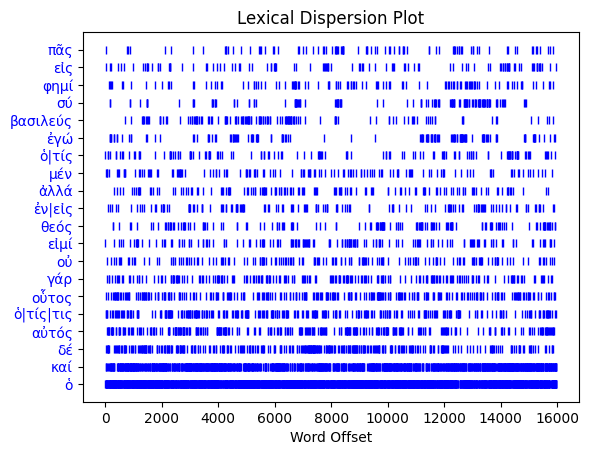

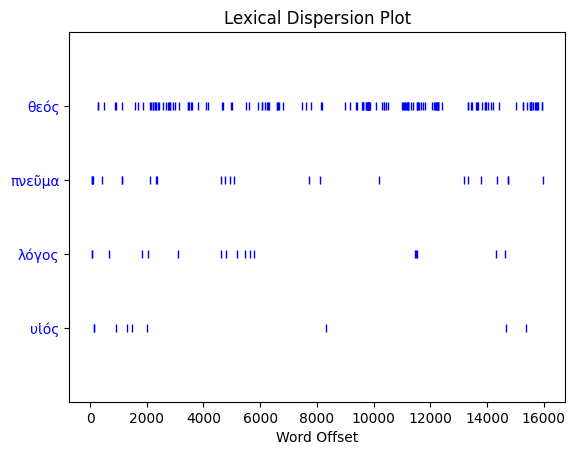

In [40]:
## Dispersion plot
from nltk.draw.dispersion import dispersion_plot
#lemmata = [d['Lemma'] for d in lemmatized]
check = list(lemma20.keys()) # 20 most used lemmata from above
dispersion_plot(lemmata, check)
# TODO: include stopword-list
dispersion_plot(lemmata, ['θεός','πνεῦμα','λόγος','υἱός'])

## Play with morphology 
TODO: tbd

In [28]:
morphology = [d['Morphology'] for d in lemmatized]
# remove duplicates and count instances
morph = {x:morphology.count(x) for x in morphology}
features = dict()
for key, value in morph.items():
    if 'place' in str(key):
        features[key] = value
print(features)

{'named entity-place-dative': 1, 'named entity-place': 6}
